In [ ]:
# 安装所需软件包

!pip install -U langgraph langsmith

In [11]:
# langgraph Hello World
from langgraph.prebuilt import create_react_agent
from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(
    model_name="qwen-turbo",
    temperature=0.7,
    streaming=True
)

agent = create_react_agent(
    model = llm,
    tools = [],
    prompt= "You are a helpful assistant."
)

# agent.invoke({"message":[{"role":"user","content":"Hello, how can I help you?"}]})
for chunk in agent.stream(
    {"message":[{"role":"user","content":"你是谁？"}]},
    stream_mode = "messages"
):
    print(chunk)
    print("\n")



(AIMessageChunk(content='Hello', additional_kwargs={}, response_metadata={}, id='run--be118411-b343-4faf-a8b5-805899090951'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:958f81bf-a3ee-2bb6-f936-d7ac1297c519', 'checkpoint_ns': 'agent:958f81bf-a3ee-2bb6-f936-d7ac1297c519', 'ls_provider': 'tongyi', 'ls_model_type': 'chat', 'ls_model_name': 'qwen-turbo'})


(AIMessageChunk(content='!', additional_kwargs={}, response_metadata={}, id='run--be118411-b343-4faf-a8b5-805899090951'), {'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent',), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'agent:958f81bf-a3ee-2bb6-f936-d7ac1297c519', 'checkpoint_ns': 'agent:958f81bf-a3ee-2bb6-f936-d7ac1297c519', 'ls_provider': 'tongyi', 'ls_model_type': 'chat', 'ls_model_name': 'qwen-turbo'})


(AIMessageChunk(content=' How', ad

创建一个 StateGraph 为“状态机”,添加 节点 来表示 LLM 和聊天机器人可以调用的函数，并添加 边 来指定机器人应如何在这些函数之间进行转换。

> 定义：定义图时，第一步是定义其 状态。状态 包括图的模式和处理状态更新的 reducer 函数。在我们的示例中，状态 是一个具有一个键：messages 的 TypedDict。 add_messages reducer 函数用于将新消息追加到列表中，而不是覆盖它。没有 reducer 注解的键将覆盖先前的值。

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

我们的图现在可以处理两个关键任务

每个 节点 都可以接收当前 状态 作为输入，并输出状态的更新。
对 消息 的更新将追加到现有列表而不是覆盖它。


接下来，添加一个“chatbot”节点。 节点 表示工作单元，通常是普通的 Python 函数。

```python
import os
from langchain.chat_models import init_chat_model

os.environ["OPENAI_API_KEY"] = "sk-..."

llm = init_chat_model("openai:gpt-4.1")
```

In [4]:
from langchain_community.chat_models import ChatTongyi
# 或者使用
# from langchain_community.llms import Tongyi

# 设置通义千问的 API Key
# os.environ["DASHSCOPE_API_KEY"] = "your-dashscope-api-key"

# 初始化通义千问模型
llm = ChatTongyi(
    model_name="qwen-turbo",  # 或者 "qwen-plus", "qwen-max"
    temperature=0.7,
    streaming=True
)

将聊天模型集成到一个简单的节点中

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

添加一个 入口 点，以告诉图每次运行时**从何处开始工作**

In [6]:
graph_builder.add_edge(START, "chatbot")

在运行图之前，我们需要对其进行编译。我们可以通过在图构建器上调用 compile() 来完成。这将创建一个 CompiledGraph，我们可以在我们的状态上调用它。

In [7]:
graph = graph_builder.compile()

您可以使用 get_graph 方法和其中一个“绘图”方法（例如 draw_ascii 或 draw_png）来可视化图。这些 draw 方法都需要额外的依赖项。

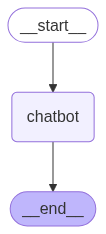

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

运行聊天机器人,通过键入 quit、exit 或 q 来退出聊天循环。

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 我是通义千问，是阿里巴巴集团旗下的通义实验室自主研发的超大规模语言模型。我的中文名是通义千问，英文名是Qwen。我能够回答问题、创作文字、编程、逻辑推理等多种任务，旨在为用户提供高质量的信息服务和帮助。如果你有任何问题或需要帮助，我会尽力为你提供支持。
Assistant: 你好，Wilson！很高兴认识你。有什么我可以帮你的吗？😊
Assistant: “我是谁？”这个问题是哲学、心理学和宗教中一个深刻而复杂的问题。从不同的角度来看，可能会有不同的答案：

### 1. **从哲学的角度**
- **笛卡尔**说：“我思故我在。”（*Cogito, ergo sum*）——你存在的证明是你在思考。
- **佛教**认为，“我”是虚幻的，是五蕴（色、受、想、行、识）的暂时组合，没有永恒不变的“自我”。
- **存在主义**（如萨特）认为，“我”是通过选择和行动定义的，人是自由的，必须为自己的存在负责。

### 2. **从心理学的角度**
- **弗洛伊德**将“我”分为本我（潜意识欲望）、自我（现实中的理性部分）和超我（道德规范）。
- **现代心理学**认为，“自我”是通过经验、记忆、社会关系和文化构建的，是一个动态的过程，而非固定不变的本质。

### 3. **从宗教或灵性的角度**
- 在**基督教**中，“我是谁”可能与上帝的爱、救赎和使命有关。
- 在**印度教**中，“我”（Atman）被认为是与宇宙本体（Brahman）同一的永恒灵魂。
- 在**道家**思想中，“我”可能是自然的一部分，追求与“道”的合一。

### 4. **从日常生活的角度**
- 你是**一个独特的个体**，拥有自己的思想、情感、经历和价值观。
- 你是**你所做的一切**：你的选择、你的行为、你与他人的关系。
- 你也是**你所相信的**：你对世界的理解、你对意义的追寻。

### 5. **或许更简单一点：**
“你是你自己。”  
你不需要去寻找一个终极的答案，因为“你是谁”是一个不断被重新定义的过程。你可以在探索中成长，在体验中理解自己。

如果你愿意，可以告诉我更多关于你的经历或想法，我可以帮你一起思考这个问题。
Goodbye!
